Authors       | Email                  |
:--------------|:----------------------|
Rezwanul      | rezwanul.cse@gmail.com |


## Problem: Predicting taxi fares in New York City
### Problem class: Supervised Regression

### Problem dataset link: [kaggle dataset link](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data) |

### Problem description:

 predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used.

### Problem Task:  Build a machine learning model to accurately predict the fare amount

# Import Libraries

In [37]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

from keras.models import Sequential
from keras.layers import Dense

# Loading data

In [2]:
df = pd.read_csv('data/NYC_taxi.csv', parse_dates=['pickup_datetime'], nrows=500000)

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


# Dataset Description
1. key: This column seems identical to the pickup_datetime column. It was
    probably used as an unique identifier in the database it was stored in. We
    can safely remove this column without any loss of information.
2. fare_amount: This is the target variable we are trying to predict, the fare
    amount paid at the end of the trip.
3. pickup_datetime: This column contains information on the pickup date
    (year, month, day of month), as well as the time (hour, minute, seconds).
4. pickup_longitude and pickup_latitude: The longitude and latitude of the pickup location
5. dropoff_longitude and dropoff_latitude: The longitude and latitude of the drop off location.
6. passenger_count: The number of passengers

# Exploratory data analysis

### Visualizing the geolocation data

In [3]:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

df2 = df.copy(deep=True)
for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] < nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] < nyc_max_latitude)]
    
# We are also interested in overlaying the scatterplot with a few key landmarks in NYC. A quick Google search tells
# us that there are two main airports in NYC (JFK and LaGuardia)

landmarks = {
    'JFK Airport': (-73.78, 40.643),
    'Laguardia Airport': (-73.87, 40.77),
    'Midtown': (-73.98, 40.76),
    'Lower Manhattan': (-74.00, 40.72),
    'Upper Manhattan': (-73.94, 40.82),
    'Brooklyn': (-73.95, 40.66)
    }

def plot_latitude_longitude(df, landmarks, points='PickUp'):
    plt.figure(figsize=(12, 12)) # figure size
    if points == 'pickup':
        plt.plot(list(df.pickup_longitude), list(df.pickup_latitude), '.', markersize=1)
    else :
        plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude), '.', markersize=1)
    
    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], '*', markersize=15, alpha=1, color='r')
        
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, landmarks[landmark][1]+0.005), 
                    color='r', backgroundcolor='w')
    
    plt.title(f"{points} Locations in NYC Illustrated")
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()


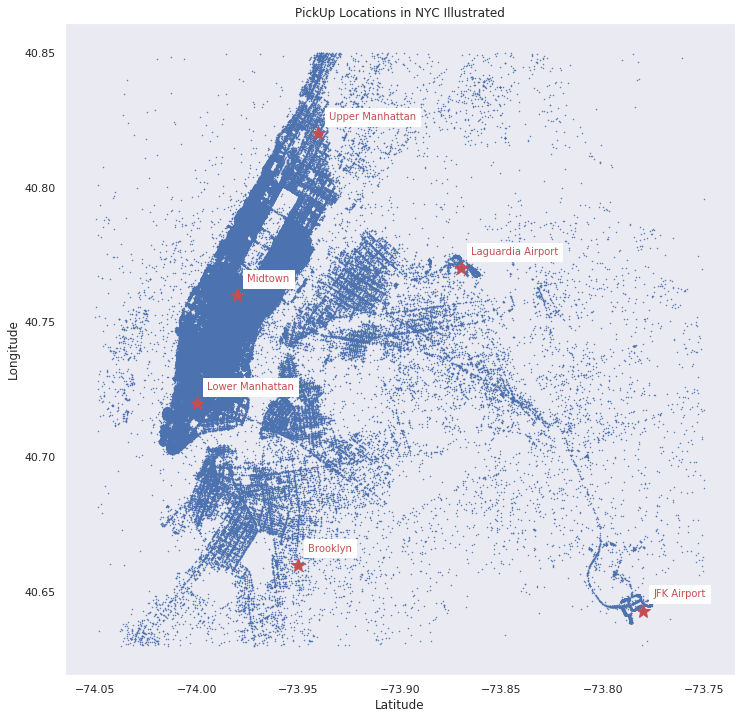

In [4]:
plot_latitude_longitude(df2, landmarks, points="PickUp")

## Insight: 
# In Manhattan, most pickups were around the Midtown area, followed by
# Lower Manhattan. In comparison, there are much fewer pickups in Upper
# Manhattan. This makes sense, since Upper Manhattan is a residential area,
# whereas more offices and tourist attractions are located at Midtown and
# Lower Manhattan.
# Pickups are sparse outside Manhattan. The only two outliers were at
# LaGuardia Airport and JFK Airport.

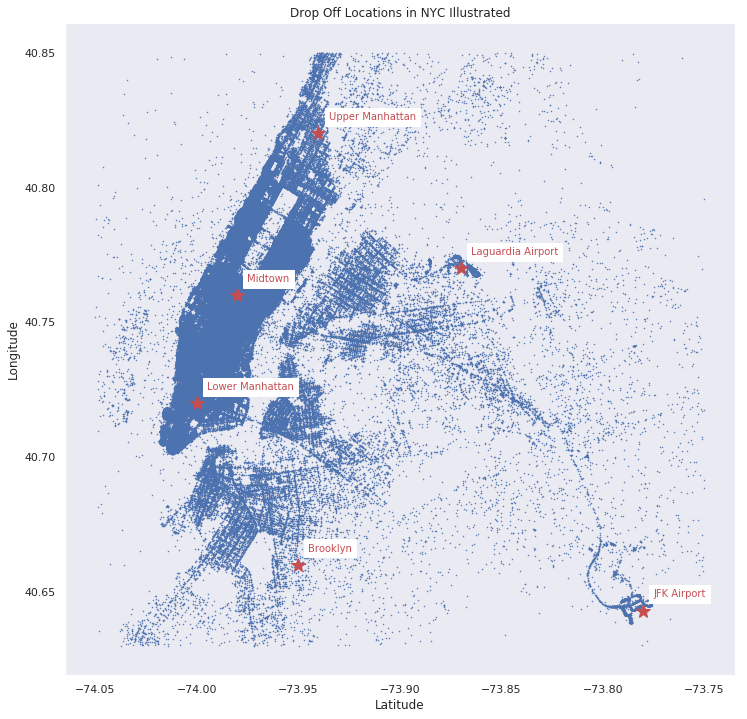

In [5]:
plot_latitude_longitude(df2, landmarks, points="Drop Off")

## Insight:
# we can clearly see that there are more drop offs than pickups in 
# residential areas such as Upper Manhattan and Brooklyn. Neat!

#### Ridership by day and hour comparision

In [6]:
# How the number of rides varies by day and hour
# pickup_datetime column contains multiple data like year, month, day, day_of_week, hour
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

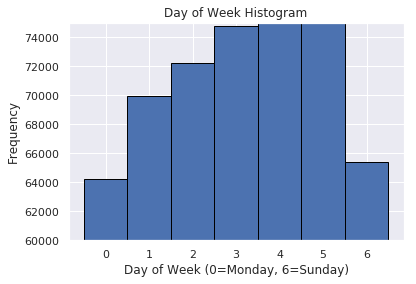

In [7]:
df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='black', ylim=(60000, 75000))
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.title('Day of Week Histogram')
plt.show()

## Insight:
# Interestingly, we can see that the number of rides is not evenly distributed
# across each weekday. Instead, the number of rides increases linearly from
# Monday through Friday, and peaking on Friday, Staturday. The weekends the 
# number of rides falling sharply on Sunday

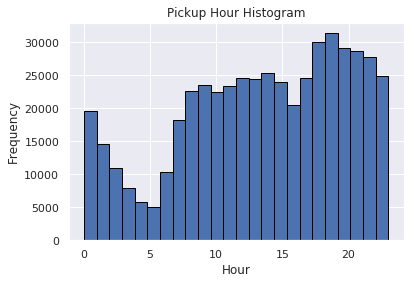

In [8]:
# ridership by hour
df['hour'].plot.hist(bins=24, ec='black')
plt.title('Pickup Hour Histogram')
plt.xlabel('Hour')
plt.show()

## Insight:
# We can see that there are more rides during the evening rush hour, as
# compared to the morning rush hour. In fact, the number of rides is pretty
# constant throughout the day. Starting at 6 P.M., the number of rides increases
# and peaks at 7 P.M., before falling from 11 P.M. onwards

# Data preprocessing

### Handling missing values and data anomalies

In [9]:
df.isnull().sum()

## Insight
# We can see that there are only five rows (out of 500,000 rows) with missing
# data. With a missing data percentage of just 0.001%, it seems that we don't
# have a problem with missing data

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64

In [10]:
# We can remove the data as it's only 0.001% of the total data
df = df.dropna()

In [11]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520091,39.920350,-72.522435,39.916526,1.683445,2011.739129,6.268617,15.684239,3.042020,13.510843
std,9.916069,11.856446,8.073318,11.797362,7.391002,1.307391,1.860897,3.437798,8.681092,1.949243,6.511596
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992047,40.734916,-73.991382,40.734057,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


In [12]:
## Insight
# The lowest fare in the dataset is $-44.90. it doesn't look correct.
# fares can't be negative! Also, the highest fare is $500

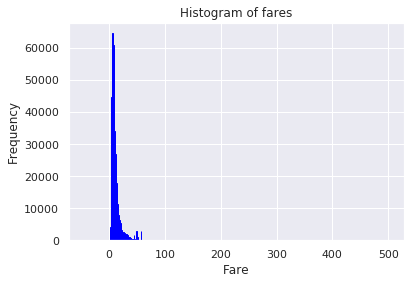

In [13]:
# For better understanding we can use histogram
df['fare_amount'].plot.hist(bins=500, ec='blue')
plt.xlabel('Fare')
plt.title("Histogram of fares")
plt.show()

## Insight:
# we can observe from the histogram is that
# there is a small spike in fares around $50. Could this be a fixed fare from a
# specific location? Cities usually implement fixed fares for trips to and from
# airports. A quick Google search tells us that trips to and from JFK airport
# incurs a flat fare of $52 plus tolls. This could be the reason for the spike in the
# histogram around $50!

In [14]:
# remove rows with fares less than $0 and more than $100
df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 100)]

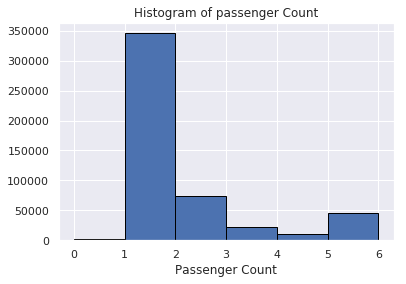

In [15]:
df['passenger_count'].hist(bins=6, ec='black')
plt.xlabel("Passenger Count")
plt.title("Histogram of passenger Count")
plt.show()

## Insight
# There's a small percentage of rows with 0 passenger counts.
# Instead of discarding those rows, let's replace the outliers 
# with the mode (that is, 1 passenger count)

In [16]:
df.loc[df['passenger_count'] == 0, 'passenger_count'] = 1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


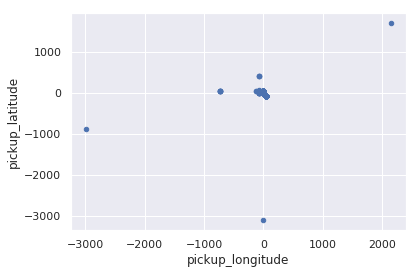

In [17]:
df.plot.scatter("pickup_longitude", 'pickup_latitude')
plt.show()

## Insight
# we can see where the outliers are? The dots at the periphery of the scatterplot
# are outliers. They have latitude values as high as 1000 and as low as -3000.
# Earth's geographic coordinate system does not have such extreme latitudes
# and longitudes

In [18]:
# remove those outliers
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

# Only consider locations within NYC
for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[long] > nyc_min_longitude) & (df[long] < nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[lat] > nyc_min_latitude) & (df[lat] < nyc_max_latitude)]

In [19]:
# Creating a helper function for data preprocessing
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # remove missing values in the dataframe
    def remove_missing_values(df: pd.DataFrame) -> pd.DataFrame:
        df = df.dropna()
        return df
    
    # replace outliers in fare amount
    def remove_fare_amount_outliers(df, lower_bound, upper_bound):
        df = df[(df['fare_amount'] >= lower_bound) & (df['fare_amount'] <= upper_bound)]
        return df
    
    # replace outliers in passenger count with the mode
    def replace_passenger_count_outliers(df):
        mode = df['passenger_count'].mode()
        df.loc[df['passenger_count'] == 0, 'passenger_count'] = mode
        return df
    
    # remove outliers in latitude and longitude
    def remove_lat_long_outliers(df):
        # range of longitude for NYC
        nyc_min_longitude = -74.05
        nyc_max_longitude = -73.75

        # range of latitude for NYC
        nyc_min_latitude = 40.63
        nyc_max_latitude = 40.85
        
        # Only consider locations within NYC
        for long in ['pickup_longitude', 'dropoff_longitude']:
            df = df[(df[long] > nyc_min_longitude) & (df[long] < nyc_max_longitude)]

        for lat in ['pickup_latitude', 'dropoff_latitude']:
            df = df[(df[lat] > nyc_min_latitude) & (df[lat] < nyc_max_latitude)]
            
        return df
    
    df = remove_missing_values(df)
    df = remove_fare_amount_outliers(df, lower_bound=0, upper_bound=100)
    df = replace_passenger_count_outliers(df)
    df = remove_lat_long_outliers(df)
    
    return df

# Feature Engineering

In [20]:
## Note
# feature engineering is the process of using one's
# domain knowledge of the problem to create new features 
# for the machine learning algorithm.

### Temporal features

In [21]:
df.head()['pickup_datetime']

0   2009-06-15 17:26:21
1   2010-01-05 16:52:16
2   2011-08-18 00:35:00
3   2012-04-21 04:30:42
4   2010-03-09 07:51:00
Name: pickup_datetime, dtype: datetime64[ns]

In [22]:
## Note
# neural networks require numerical features. Therefore, we can't
# train our neural network using such a datetime string. Let's separate
# the pickup_datetime column into different columns for year, month, day, day_of_week,
# and hour

df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

In [23]:
df.loc[:5, ['pickup_datetime', 'year', 'month', 'day', 'day_of_week', 'hour']]

,pickup_datetime,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21,2009,6,15,0,17
1,2010-01-05 16:52:16,2010,1,5,1,16
2,2011-08-18 00:35:00,2011,8,18,3,0
3,2012-04-21 04:30:42,2012,4,21,5,4
4,2010-03-09 07:51:00,2010,3,9,1,7
5,2011-01-06 09:50:45,2011,1,6,3,9


In [24]:
# We can see that the new columns capture the original information from
# the pickup_datetime column in a format that's suitable for our neural network.
# Let's drop the pickup_datetime column from our DataFrame
df = df.drop(['pickup_datetime'], axis=1)

### Geolocation features

In [25]:
## Insight:
# The dataset contains information regarding the pickup
# and drop off coordinates. However, there is no information regarding the
# distance between the pickup and drop off points, which is arguably the most
# important factor in deciding taxi fares

#### Recall from geometry that the Euclidean Distance is the straight-line distance between any two points

![Euclidean Distance](images/Euclidean_Distance.png)

In [26]:
def euclidean_distance(lat1, long1, lat2, long2):
    return (((lat1-lat2)**2 + (long1-long2)**2)**0.5)

In [27]:
df['distance'] = euclidean_distance(df['pickup_latitude'],
                                    df['pickup_longitude'],
                                    df['dropoff_latitude'],
                                    df['dropoff_longitude']
                                   )

## Note
# Our hypothesis was that the trip fare is closely correlated to the distance
# traveled. We can now plot the two variables on a scatterplot to analyze the
# correlation and see if our intuition was right

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


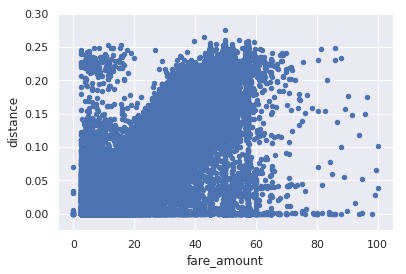

In [28]:
df.plot.scatter('fare_amount', 'distance')
plt.show()

## Insight
# Nice! We can clearly see that our hypothesis is right. However, the distance
# traveled alone does not tell the whole story. If we look at the center of the
# graph, we can see three vertical lines of dots. These outlier data seems to
# suggest that there are certain trips where the distance traveled did not have an
# impact on the fare amount (which is between $40 and $60 for these outliers).
# we saw that there are certain pickups near airports, and these airport pickups have 
# a flat fare of $52 plus tolls. This could explain the three vertical lines of dots
# between $40 and $60!

In [31]:
## New feature Idea:
# we need to engineer a new feature that informs our neural network of
# the pickup and drop off distance from the three major airports in NYC.
airports = {
    'JFK_Airport': (-73.78, 40.643),
    'Laguardia_Airport': (-73.87, 40.77),
    'Newark_Airport': (-74.18, 40.69)
}

for airport in airports:
    df['pickup_dist_' + airport] = euclidean_distance(df['pickup_latitude'], 
                                                      df['pickup_longitude'], 
                                                      airports[airport][1],
                                                      airports[airport][0],
                                                     )
    
    df['dropoff_dist_' + airport] = euclidean_distance(df['dropoff_latitude'], 
                                                      df['dropoff_longitude'], 
                                                      airports[airport][1],
                                                      airports[airport][0],
                                                     )

In [32]:
df[['key', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_dist_JFK_Airport', 'dropoff_dist_JFK_Airport']].head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport
0,2009-06-15 17:26:21.0000001,-73.844311,40.721319,-73.841610,40.712278,0.101340,0.092710
1,2010-01-05 16:52:16.0000002,-74.016048,40.711303,-73.979268,40.782004,0.245731,0.242961
2,2011-08-18 00:35:00.00000049,-73.982738,40.761270,-73.991242,40.750562,0.234714,0.237050
3,2012-04-21 04:30:42.0000001,-73.987130,40.733143,-73.991567,40.758092,0.225895,0.240846
4,2010-03-09 07:51:00.000000135,-73.968095,40.768008,-73.956655,40.783762,0.225847,0.225878


In [33]:
df = df.drop(['key'], axis=1)

In [34]:
# Helper methid for feature engineer
def feature_engineer(df):
    # Create new columns for year, month, day, day of week, and hour
    def create_time_features(df):
        df['year'] = df['pickup_datetime'].dt.year
        df['month'] = df['pickup_datetime'].dt.month
        df['day'] = df['pickup_datetime'].dt.day
        df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
        df['hour'] = df['pickup_datetime'].dt.hour
        
        df = df.drop(['pickup_datetime'], axis=1)
        
        return df
    
    # Function to calculate euclidean distance
    def euclidean_distance(lat1, long1, lat2, long2):
        return (((lat1-lat2)**2 + (long1-long2)**2)**0.5)
    
    # Create new function for the distance travelled
    def create_pickup_dropoff_dist_features(df):
        df['travel_distance'] = euclidean_distance(df['pickup_latitude'],
                                    df['pickup_longitude'],
                                    df['dropoff_latitude'],
                                    df['dropoff_longitude']
                                   )
        return df
    
    # Create new column for the distance away from airports
    def create_airport_dist_features(df):
        airports = {
            'JFK_Airport': (-73.78, 40.643),
            'Laguardia_Airport': (-73.87, 40.77),
            'Newark_Airport': (-74.18, 40.69)
        }

        for airport in airports:
            df['pickup_dist_' + airport] = euclidean_distance(df['pickup_latitude'], 
                                                              df['pickup_longitude'], 
                                                              airports[airport][1],
                                                              airports[airport][0],
                                                             )

            df['dropoff_dist_' + airport] = euclidean_distance(df['dropoff_latitude'], 
                                                              df['dropoff_longitude'], 
                                                              airports[airport][1],
                                                              airports[airport][0],
                                                             )
            
        return df
    
    df = create_time_features(df)
    df = create_pickup_dropoff_dist_features(df)
    df = create_airport_dist_features(df)
    df = df.drop(['key'], axis=1)
    
    return df

# Feature scaling

In [35]:
df_prescaled = df.copy()

In [36]:
df_scaled = df.drop(['fare_amount'], axis=1)

In [38]:
df_scaled = scale(df_scaled)

In [39]:
cols = df.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
df_scaled = pd.concat([df_scaled, df['fare_amount']], axis=1)
df = df_scaled.copy()

# Deep Feedforward networks

# Spliting the data into training, testing, validation sets

In [29]:
# ### Training set: 
# The neural network will be trained on this subset of the data.
# ### Validation set: 
# This set of data allows us to perform hyperparameter tuning (that is, 
# tuning the number of hidden layers) using an unbiased source of data.
# ### Testing set: 
# The final evaluation of the neural network will be based on this subset 
# of the data.

#### 80% training and 20% testing, and then to split the training data into 80% training and 20% validation again

In [30]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NameError: name 'X' is not defined

In [ ]:
# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Model Selection

## Model architecture

| Input Layer -> | 1st Hidden Layer ->| 2nd Hidden Layer -> | Output Layer |
:--------------|:----------------------|:--------------|:----------------------|

### Activation functions
1. ReLU
2. Sigmoid

##### ReLU (Rectified Linear Unit)
ReLU is always used as the activation function for our intermediate hidden layers (that is, non-output layer)

##### Sigmoid
It squashes the output between 0 and 1 (binary output).

# Model Building

In [ ]:
model = Sequential()

In [ ]:
# Add the first hidden layer
model.add(Dense(32, activation='relu', input_dim=8))

# Add the second hidden layer
model.add(Dense(16, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Model compilation

#### Optimizer: 
Let's use the adam optimizer, which is a popular optimizer in Keras. 
For most datasets, the adam optimizer will work well without much
tuning.
#### Loss function: 
We'll use binary_crossentropy as our loss function since the
problem at hand is a binary classification problem.
#### Metrics: 
We'll use accuracy (that is, the percentage of correctly classified
samples) as our evaluation metric.

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

# Model Training

In [ ]:
# Train the model for 200 epochs
model.fit(X_train, y_train, epochs=200)

# Result Analysis

In [ ]:
# Having successfully trained our "  ", let's evaluate our model based on the
# testing accuracy, confusion matrix, and receiver operating characteristic
# (ROC) curve.

### Testing accuracy

In [ ]:
scores = model.evaluate(X_train, y_train)
print(f"Training Accuracy: {scores[1] * 100}\n")

scores = model.evaluate(X_test, y_test)
print(f"Testing Accuracy: {scores[1] * 100}\n")

## Confusion matrix

In [ ]:
# The confusion matrix is a useful visualization tool that provides analysis on
# the true negative, false positive, false negative, and true positives made by our
# model

# True negative: Actual class is negative (no diabetes), and the model predicted negative (no diabetes)
# False positive: Actual class is negative (no diabetes), but the model predicted positive (diabetes)
# False negative: Actual class is positive (diabetes), but the model predicted negative (no diabetes)
# True positive: Actual class is positive (diabetes), and the model predicted positive (diabetes)

In [ ]:
y_test_pred = model.predict_classes(X_test)
c_matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(c_matrix, annot=True,
                 xticklabels=['No Diabetes', 'Diabetes'],
                 yticklabels=['No Diabetes', 'Diabetes'],
                 cbar=False, cmap='Blues'
                )
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")

## Roc Curve

In [ ]:
# The ROC curve is a plot with the True Positive Rate (TPR) on the y axis and the False Positive Rate (FPR) on the x axis
# Analyze the ROC curve, we look at the area under the curve (AUC) to evaluate the performance of the model that produced the curve. 
# A large AUC indicates that the model is able to differentiate the respective classes with high accuracy, while a low AUC indicates 
# that the model makes poor, often wrong predictions. A ROC curve that lies on the diagonal indicates that the model does no better 
# than random

In [ ]:
y_test_pred_probs = model.predict(X_test)

In [ ]:
FPR, TPR, _= roc_curve(y_test, y_test_pred_probs)

In [ ]:
# Ploting False positive rate and True positive rate
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black')  # diagonal line
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
# Feature engineering is the process of using one's domain knowledge of the problem to create new features for the machine learning algorithm

# Feature selection is used when we believe that the original dataset contains too much noise, and removing the noisy features (features that are 
# not strong predictors) may improve model performance